In [1]:
!git clone https://github.com/aglie/seminar_disorder_2025.git

fatal: destination path 'seminar_disorder_2025' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.2 MB/s eta 0:00:00


In [17]:
cd seminar_disorder_2025

/content/seminar_disorder_2025


In [13]:
!pip install ase
!pip install gemmi

# Code for running common functionality

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
from CalculateScattering import Grid, save_to_yell

from numpy.fft import fftshift, ifftn, fftn
from numpy import real, imag, angle

#-------- Initialize Lattice -----
def initialize_lattice(size=(50, 50)):
    # Create a 50/50 mixture of Cu (+1) and Au (-1) atoms
    num_sites = size[0] * size[1]
    half_sites = num_sites // 2

    # Create array with exactly 50% +1 and 50% -1
    flat_lattice = np.ones(num_sites, dtype=np.int8)
    flat_lattice[half_sites:] = -1

    # Shuffle the array and reshape to 2D
    np.random.shuffle(flat_lattice)
    return flat_lattice.reshape(size)

#-------- Calculate Energy -----
def calculate_energy(lattice, interactions):
    energy = 0.0
    height, width = lattice.shape

    for i in range(height):
        for j in range(width):
            spin = lattice[i, j]

            # Calculate interaction energy with neighbors
            for dx, dy, J in interactions:
                # Apply periodic boundary conditions
                ni, nj = (i + dy) % height, (j + dx) % width
                neighbor_spin = lattice[ni, nj]

                # Ising interaction: -J*s_i*s_j
                energy -= J * spin * neighbor_spin

    # We've counted each interaction twice
    return energy / 2.0

def calculate_swap_energy_change(lattice, i1, j1, i2, j2, interactions, height, width):
    energy_before = 0.0
    energy_after = 0.0

    # Energy contribution from site 1
    for dx, dy, J in interactions:
        ni1 = (i1 + dy) % height
        nj1 = (j1 + dx) % width
        neighbor_spin = lattice[ni1, nj1]
        energy_before -= J * lattice[i1, j1] * neighbor_spin
        energy_after -= J * lattice[i2, j2] * neighbor_spin

    # Energy contribution from site 2
    for dx, dy, J in interactions:
        ni2 = (i2 + dy) % height
        nj2 = (j2 + dx) % width
        neighbor_spin = lattice[ni2, nj2]
        energy_before -= J * lattice[i2, j2] * neighbor_spin
        energy_after -= J * lattice[i1, j1] * neighbor_spin

    # Correct for double counting if sites are neighbors
    for dx, dy, J in interactions:
        if ((i1 + dy) % height == i2 and (j1 + dx) % width == j2) or \
           ((i2 + dy) % height == i1 and (j2 + dx) % width == j1):
            energy_before -= J * lattice[i1, j1] * lattice[i2, j2]
            energy_after -= J * lattice[i2, j2] * lattice[i1, j1]

    return energy_after - energy_before

#-------- Monte Carlo Simulation -----
def run_mc_until_accepted(lattice, interactions, n_accepted, temperature):
    height, width = lattice.shape
    accepted_good = 0
    accepted_bad = 0
    rejected = 0
    total_accepted = 0

    while total_accepted < n_accepted:
        # Find two sites with different occupancies
        while True:
            i1, j1 = np.random.randint(0, height), np.random.randint(0, width)
            i2, j2 = np.random.randint(0, height), np.random.randint(0, width)

            if lattice[i1, j1] != lattice[i2, j2]:
                break

        # Calculate energy change
        delta_energy = calculate_swap_energy_change(
            lattice, i1, j1, i2, j2, interactions, height, width
        )

        # Metropolis acceptance criterion
        if delta_energy <= 0:
            # Accept the move: swap the spins
            tmp = lattice[i1, j1]
            lattice[i1, j1] = lattice[i2, j2]
            lattice[i2, j2] = tmp
            accepted_good += 1
            total_accepted += 1
        elif np.random.random() < np.exp(-delta_energy/temperature):
            # Accept the move despite energy increase
            tmp = lattice[i1, j1]
            lattice[i1, j1] = lattice[i2, j2]
            lattice[i2, j2] = tmp
            accepted_bad += 1
            total_accepted += 1
        else:
            # Reject the move
            rejected += 1

    return lattice, accepted_good, accepted_bad, rejected

def run_monte_carlo(lattice, interactions, total_accepted_moves, equilibration_steps, temperature, save_every=1000):
    # Make a copy of the input lattice to avoid modifying the original
    current_lattice = lattice.copy()

    # Initialize history
    history = []

    # Initialize counters
    accepted_good = 0
    accepted_bad = 0
    rejected_moves = 0

    # Run equilibration
    if equilibration_steps > 0:
        print(f"Running {equilibration_steps} equilibration steps...")
        current_lattice, eq_good, eq_bad, eq_rejected = run_mc_until_accepted(
            current_lattice, interactions, equilibration_steps, temperature
        )

        # Update statistics
        accepted_good += eq_good
        accepted_bad += eq_bad
        rejected_moves += eq_rejected

        print(f"Equilibration complete.")

    # Save initial (post-equilibration) configuration
    history.append(current_lattice.copy())

    # Number of saves we'll make
    num_saves = total_accepted_moves // save_every
    print(f"Will save {num_saves} configurations during production run")

    # Run production with progress bar
    print(f"Running production: {total_accepted_moves} accepted moves...")
    remaining = total_accepted_moves

    with tqdm(total=total_accepted_moves) as pbar:
        while remaining > 0:
            # Determine how many moves to accept before next save
            moves_to_accept = min(remaining, save_every)

            # Run Monte Carlo until exactly moves_to_accept moves are accepted
            current_lattice, good, bad, rej = run_mc_until_accepted(
                current_lattice, interactions, moves_to_accept, temperature
            )

            # Update statistics
            accepted_good += good
            accepted_bad += bad
            rejected_moves += rej
            remaining -= moves_to_accept

            # Update progress bar
            pbar.update(moves_to_accept)

            # Save configuration
            if moves_to_accept == save_every:
                history.append(current_lattice.copy())

    # Calculate total moves
    total_moves = accepted_good + accepted_bad + rejected_moves

    # Calculate statistics
    stats = {
        "accepted_good": accepted_good,
        "accepted_bad": accepted_bad,
        "rejected": rejected_moves,
        "total_moves": total_moves,
        "accepted_ratio": (accepted_good + accepted_bad) / total_moves
    }

    print(f"Move statistics:")
    print(f"  Accepted (energy lowering): {accepted_good}/{total_moves} ({100*accepted_good/total_moves:.2f}%)")
    print(f"  Accepted (energy raising): {accepted_bad}/{total_moves} ({100*accepted_bad/total_moves:.2f}%)")
    print(f"  Rejected: {rejected_moves}/{total_moves} ({100*rejected_moves/total_moves:.2f}%)")
    print(f"  Total acceptance ratio: {100*(accepted_good+accepted_bad)/total_moves:.2f}%")

    return history, current_lattice, stats

#-------- Visualization -----
def visualize_lattice(lattice):
    plt.figure(figsize=(8, 8))
    # Use a colormap: blue for Cu (+1), red for Au (-1)
    plt.imshow(lattice, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar(ticks=[-1, 1], label='Atom Type (Cu: +1, Au: -1)')
    plt.title("Disordered Solid Configuration")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def convert_lattice_to_crystal_structure(lattice, a=3):
    """
    Convert a 2D lattice of +1 (Cu) and -1 (Au) into a 3D CrystalStructure

    Parameters:
    -----------
    lattice: 2D numpy array
        Array of +1 (Cu) and -1 (Au) values
    a: float
        Lattice parameter in Å

    Returns:
    --------
    CrystalStructure
        3D crystal structure for calculating scattering
    """
    # Import here to avoid circular imports
    from CalculateScattering import CrystalStructure

    height, width = lattice.shape

    # Create atoms list (element_type, x, y, z)
    atoms = []
    for x in range(height):
        for y in range(width):
            # Convert +1 to Cu, -1 to Au
            element = "Cu" if lattice[x, y] == 1 else "Au"
            atoms.append((element, x, y, 0))

    # Create crystal structure with a simple cubic unit cell
    # We set the supercell to the lattice dimensions
    crystal = CrystalStructure(
        cell_parameters=(a, a, a, 90, 90, 90),  # Simple cubic cell
        atoms=atoms,
        supercell=(width, height, 1)  # 2D structure with thickness of 1
    )

    return crystal

def calculate_and_visualize_diffuse_scattering(lattice, output_file="diffuse_scattering.h5"):
    """
    Calculate and visualize diffuse scattering from a 2D lattice

    Parameters:
    -----------
    lattice: 2D numpy array
        Array of +1 (Cu) and -1 (Au) values
    output_file: str
        Filename to save the scattering data
    """
    # Import here to avoid circular imports
    import os
    from CalculateScattering import Grid, save_to_yell

    # Convert lattice to crystal structure
    crystal = convert_lattice_to_crystal_structure(lattice)

    # Create grid for scattering calculation
    grid = Grid(
        lower_limits=[-10, -10, 0],  # q-vector lower limits
        step_sizes=[0.1, 0.1, 1],    # q-vector step sizes
        no_pixels=[200, 200, 1]      # number of grid points in each direction
    )

    # Calculate scattering
    print("Calculating diffuse scattering...")
    sf = crystal.calculate_scattering(grid, blur=0.5, crop=1.5)

    # Get intensities and visualize
    intensities = sf.get_intensities()
    intensities = intensities[:, :, 0]  # Extract 2D plane from 3D data

    # Visualize
    plt.figure(figsize=(10, 8))
    plt.imshow(np.log1p(intensities), cmap='viridis', origin='lower')
    plt.colorbar(label='Log(Intensity + 1)')
    plt.title("Diffuse Scattering")
    plt.xlabel("q_x")
    plt.ylabel("q_y")
    plt.tight_layout()

    # Save the plot
    plt.savefig(output_file.replace('.h5', '.png'))
    plt.show()

    # Save scattering data in Yell format
    atoms = crystal.to_ase_atoms()
    output_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), output_file)
    save_to_yell(output_path, atoms, sf)
    print(f"Scattering data saved to {output_file}")


def centered_FFT(intensity):
    """Calculates a Fast Fourier Transform of electron density, assuming the origin is in the centre of the map"""
    return real(fftshift(fftn(fftshift(intensity))))

def centered_iFFT(intensity):
    """Calculates a Fast Fourier Transform of electron density, assuming the origin is in the centre of the map"""
    return real(fftshift(ifftn(fftshift(intensity))))

# Start here

In order to run a Monte Carlo simulation we need to finrst define the lattice that we will be working on. Lattice is initialized with random orientation of Cu and Au in a 2D crystal. We eoncode such configuration with +1 and -1 values on a 2D array.

Initial energy: 6.0


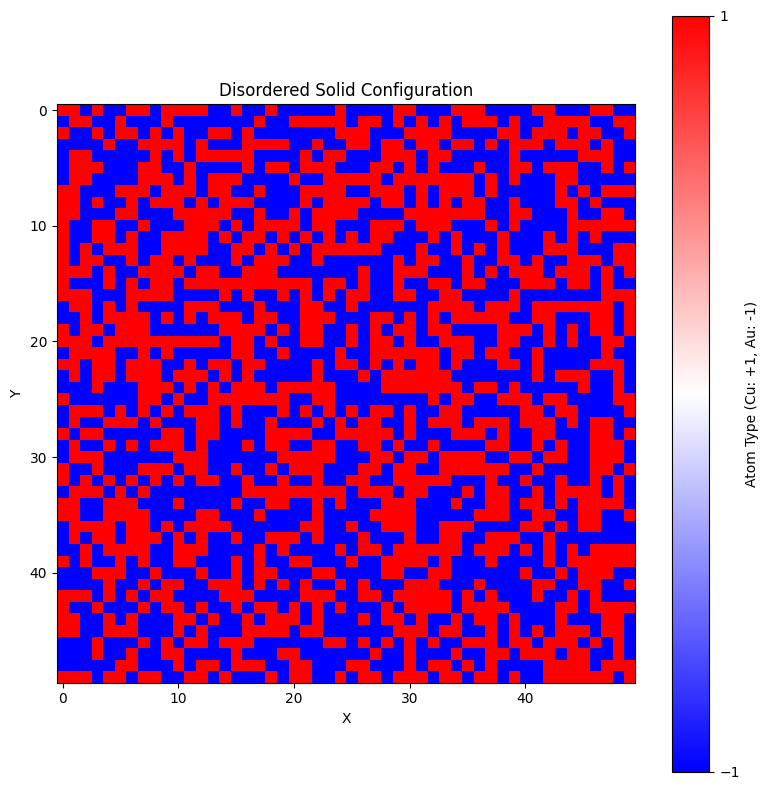

In [20]:
# Define parameters
lattice_size = (50, 50)

J1 = -0.5

# Define interactions (nearest neighbors by default)
interactions = [
    (1, 0, J1),
    (0, 1, J1),
    (-1, 0, J1),
    (0, -1, J1)
]

# Initialize lattice
initial_lattice = initialize_lattice(size=lattice_size)

# Calculate initial energy
initial_energy = calculate_energy(initial_lattice, interactions)
print(f"Initial energy: {initial_energy}")

# Visualize initial configuration
visualize_lattice(initial_lattice)

# Run Monte Carlo simulation

Running 1000 equilibration steps...
Equilibration complete.
Will save 1 configurations during production run
Running production: 1001 accepted moves...


100%|██████████| 1001/1001 [00:00<00:00, 3803.81it/s]


Move statistics:
  Accepted (energy lowering): 1737/6563 (26.47%)
  Accepted (energy raising): 264/6563 (4.02%)
  Rejected: 4562/6563 (69.51%)
  Total acceptance ratio: 30.49%
Final energy: -1218.0


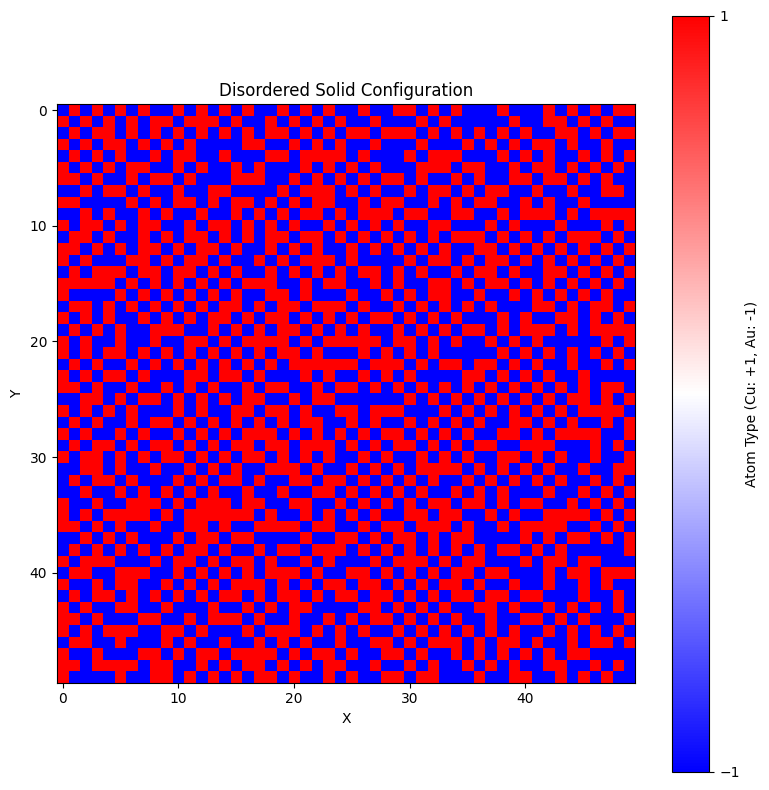

In [21]:
# Run Monte Carlo simulation
history, final_lattice, stats = run_monte_carlo(
    initial_lattice,
    interactions,
    equilibration_steps=1000, # run for
    total_accepted_moves=1001, #first equilibrate the structure
    temperature=1.0,
    save_every=1000 #Normally one would save a few structures as simulation goes. Here we will only save one for making it fast
)

# Calculate final energy
final_energy = calculate_energy(final_lattice, interactions)
print(f"Final energy: {final_energy}")

# Visualize final configuration
visualize_lattice(final_lattice)


In [22]:
# Convert lattice to crystal structure
crystal = convert_lattice_to_crystal_structure(final_lattice)

#save cif file, show how to open it in vesta
crystal.save_cif('test.cif')


Structure saved to test.cif


In [23]:
# Create grid for scattering calculation
# We will create a grid for calculating diffuse scattering from h=-10...10 and k=-10...10
ll=10 #Grid limit, in reciprocal space units
grid = Grid(
    lower_limits=[-ll, -ll, -1],  # q-vector lower limits
    step_sizes=[1/lattice_size[0], 1/lattice_size[1], 1],    # q-vector step sizes, step size is related to the supercell size
    no_pixels=[ll*2*lattice_size[0], ll*2*lattice_size[1], 2]      # number of grid points in each direction
)

# Calculate scattering structure factors
sf = crystal.calculate_scattering(grid, blur=0.01)

In [24]:
# Get intensities and visualize
intensities = sf.get_intensities()[:,:,1]

#scale them
intensities = intensities/np.amax(intensities)

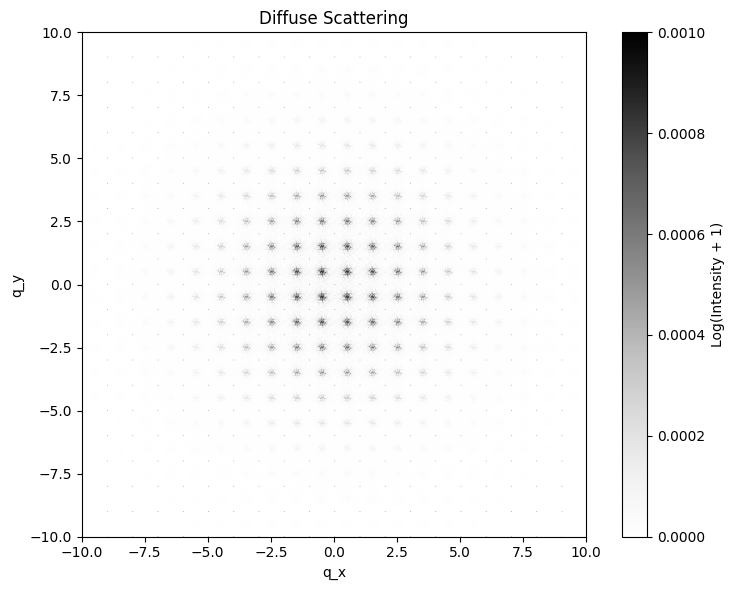

In [25]:
# Visualize
plt.figure(figsize=(8, 6))
cl = 0.001
plt.imshow(intensities, cmap='Greys', clim=[0,cl], origin='lower', extent = [grid.lower_limits[0], -grid.lower_limits[0], grid.lower_limits[1], -grid.lower_limits[1]])
plt.colorbar(label='Log(Intensity + 1)')
plt.title("Diffuse Scattering")
plt.xlabel("q_x")
plt.ylabel("q_y")
plt.tight_layout()

(np.float64(-2.5), np.float64(2.5), np.float64(-2.5), np.float64(2.5))

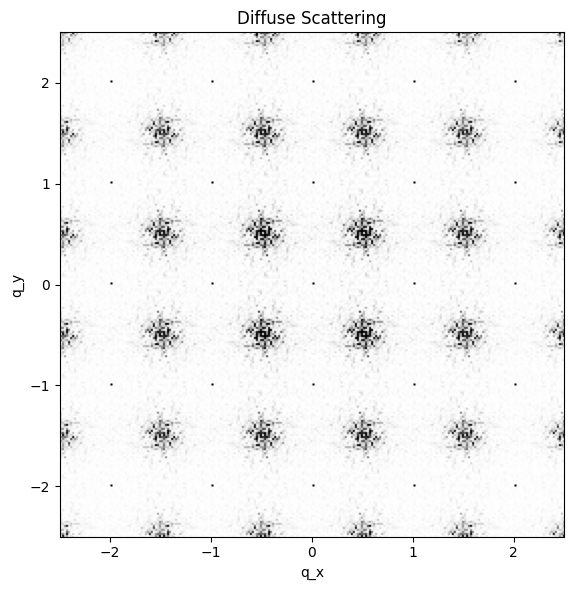

In [26]:
# Visualize them a bit closer
plt.figure(figsize=(8, 6))
cl = 0.001
plt.imshow(intensities,
           cmap='Greys',
           clim=[0,cl],
           origin='lower',
           extent = [grid.lower_limits[0], -grid.lower_limits[0], grid.lower_limits[1], -grid.lower_limits[1]])
plt.title("Diffuse Scattering")
plt.xlabel("q_x")
plt.ylabel("q_y")
plt.tight_layout()
plt.axis([-2.5,2.5,-2.5,2.5])

# Calculate electron density

(np.float64(0.5), np.float64(4.5), np.float64(0.5), np.float64(4.5))

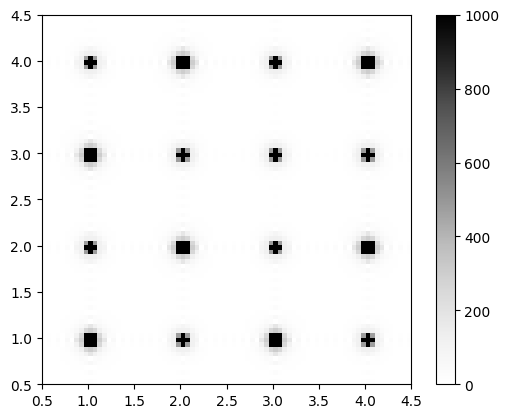

In [35]:
F = sf.values[:,:,1]  #array of structure factors
electrons_dnesity = centered_iFFT(F)
cl = 1e+3
plt.imshow(electrons_dnesity, clim=[0,cl], cmap='Greys', extent=[0, lattice_size[0], 0, lattice_size[1]])
plt.colorbar()
plt.axis([0.5,4.5,0.5,4.5])

In [36]:
# Calculate Pair Distribution function

(np.float64(-3.0), np.float64(3.0), np.float64(-3.0), np.float64(3.0))

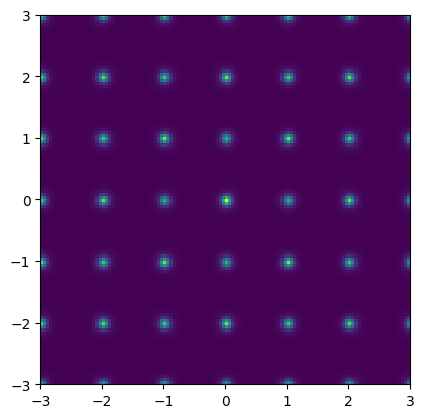

In [37]:
PDF = centered_FFT(intensities)

plt.imshow(PDF, extent=[-lattice_size[0]/2,lattice_size[0]/2, -lattice_size[1]/2, lattice_size[1]/2])
sz = 3
plt.axis([-sz,sz,-sz,sz])

(np.float64(-2.5), np.float64(2.5), np.float64(-2.5), np.float64(2.5))

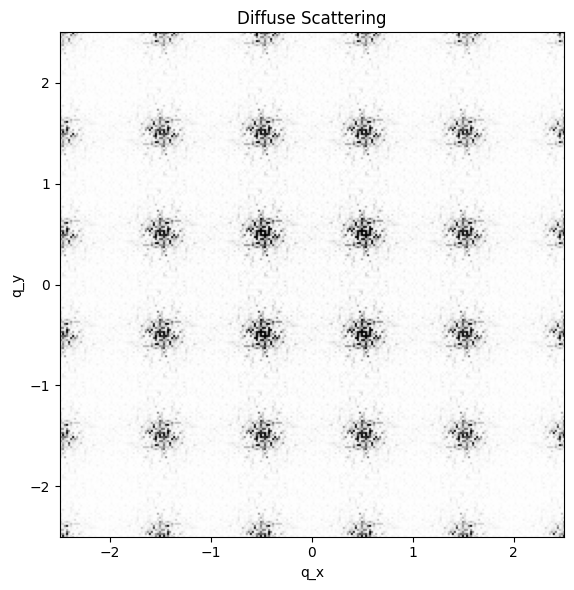

In [38]:
#Punch Bragg peaks. Here it is easy to do since Bragg peaks occupy a single pixel always
punched_intensities = intensities.copy()
punched_intensities[::lattice_size[0], ::lattice_size[1]] = 0

# Visualize
plt.figure(figsize=(8, 6))
cl = 0.001
plt.imshow(punched_intensities,
           cmap='Greys',
           clim=[0,cl],
           origin='lower',
           extent = [grid.lower_limits[0], -grid.lower_limits[0], grid.lower_limits[1], -grid.lower_limits[1]])
plt.title("Diffuse Scattering")
plt.xlabel("q_x")
plt.ylabel("q_y")
plt.tight_layout()
plt.axis([-2.5,2.5,-2.5,2.5])

(np.float64(-3.0), np.float64(3.0), np.float64(-3.0), np.float64(3.0))

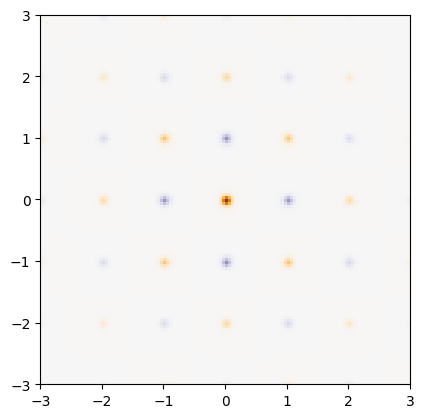

In [39]:
DeltaPDF = centered_FFT(punched_intensities)

clim = np.amax(DeltaPDF)

plt.imshow(DeltaPDF,
           clim=[-clim,clim],
           extent=[-lattice_size[0]/2,lattice_size[0]/2, -lattice_size[1]/2, lattice_size[1]/2],
          cmap='PuOr_r')
sz = 3
plt.axis([-sz,sz,-sz,sz])

# Exercises

Change interaction value from negative to positive. Notice the following;
- how does it change the structure?
- how does it change diffuse scattering?
- how does it change ∆PDF map?